## Introduction
### We are exploring the ability to use averages per game on different statistics to predict if a player will be an all-star or not in the NBA
### A few things we want to explore are: how accuracy of our models changes as fans became the voters for all-stars, how the three-point line impacts our results, and which features yield the greatest matches

### Importing required libraries

In [57]:
import pandas as pd
import sklearn as sk
import plotly
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

### Reading in the two main datasets and doing some data manipulation
### allstar_selections_data contains all the all-star selections since 1951
### player_per_game_data contains all player stats per game (ex: points per game [PPG]) since 1947

In [49]:
# Helper function to get the results for the all-stars
def is_all_star(name, year, allstar_df):
    temp_df = allstar_df.loc[(allstar_df["player"] == name) & (allstar_df["season"] == year)]
    if len(temp_df) == 0:
        return 0
    return 1

In [50]:
allstar_selections_data

,player,team,lg,season,replaced
0,Bam Adebayo,Giannis,NBA,2023,False
1,Giannis Antetokounmpo,Giannis,NBA,2023,False
2,DeMar DeRozan,Giannis,NBA,2023,False
3,Kevin Durant,Giannis,NBA,2023,False
4,Shai Gilgeous-Alexander,Giannis,NBA,2023,False
...,...,...,...,...,...
1969,Alex Groza,West,NBA,1951,False
1970,George Mikan,West,NBA,1951,False
1971,Vern Mikkelsen,West,NBA,1951,False
1972,Jim Pollard,West,NBA,1951,False


In [74]:
allstar_selections_data = pd.read_csv('All-Star Selections.csv')
allstar_selections_data = allstar_selections_data.drop_duplicates(subset=['player', 'season'])
player_per_game_data = pd.read_csv("Player Per Game.csv")
player_per_game_data = player_per_game_data.drop_duplicates()
player_per_game_data = player_per_game_data[player_per_game_data["season"] >= 1951]

tagged_player_per_game_data = player_per_game_data.copy()
tagged_player_per_game_data['is-all-star'] = tagged_player_per_game_data.apply(lambda x: is_all_star(x["player"], x["season"], allstar_selections_data), axis=1)
tagged_player_per_game_data = tagged_player_per_game_data.drop_duplicates(subset=['player', 'season'])
tagged_player_per_game_data = tagged_player_per_game_data.drop(columns=['seas_id', 'birth_year', 'player_id', 'gs'])
tagged_player_per_game_data = tagged_player_per_game_data.dropna()

In [164]:
tagged_player_per_game_data[tagged_player_per_game_data["is-all-star"] == 1]
# Note: had to drop a bunch of data due to NaN's being annoying

,season,player,pos,age,experience,lg,tm,g,mp_per_game,fg_per_game,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,is-all-star
25,2023,Anthony Edwards,SG,21.0,3,NBA,MIN,79,36.0,8.9,...,0.6,5.2,5.8,4.4,1.6,0.7,3.3,2.4,24.6,1
31,2023,Bam Adebayo,C,25.0,6,NBA,MIA,75,34.6,8.0,...,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4,1
103,2023,Damian Lillard,PG,32.0,11,NBA,POR,58,36.3,9.6,...,0.8,4.0,4.8,7.3,0.9,0.3,3.3,1.9,32.2,1
127,2023,De'Aaron Fox,PG,25.0,6,NBA,SAC,73,33.4,9.3,...,0.5,3.6,4.2,6.1,1.1,0.3,2.5,2.4,25.0,1
135,2023,DeMar DeRozan,SF,33.0,14,NBA,CHI,74,36.2,8.9,...,0.5,4.2,4.6,5.1,1.1,0.5,2.1,2.5,24.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25484,1974,Willie Wise,SF,26.0,5,ABA,UTS,82,40.1,8.7,...,2.1,5.5,7.6,3.7,1.4,0.5,2.5,3.0,22.3,1
25496,1973,Artis Gilmore,C,23.0,2,ABA,KEN,84,41.7,8.2,...,5.3,12.2,17.6,3.5,0.9,3.1,3.4,3.6,20.8,1
25579,1973,Dan Issel,PF,24.0,3,ABA,KEN,84,42.0,10.7,...,3.9,7.1,11.0,2.6,1.1,0.5,2.6,3.0,27.3,1
25745,1973,Julius Erving,SF,22.0,2,ABA,VIR,71,42.2,12.6,...,3.7,8.5,12.2,4.2,2.5,1.8,4.6,2.8,31.9,1


### TODO: add graphs of the features for visualization

## Helper function for generating training and testing data

In [106]:
def generate_train_test_data(years='all', testsize=0.2, randomstate=42):
    if years =='all':
        X = tagged_player_per_game_data.drop(columns=['player', 'pos', 'season', 'is-all-star', 'lg', 'tm'])
        y = tagged_player_per_game_data['is-all-star'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
    else:
        years_split = years.split('.')
        year_start = int(years_split[0])
        year_end = int(years_split[1])
        temp_df = tagged_player_per_game_data.copy()
        temp_df = temp_df.loc[(temp_df['season'] >= year_start) & (temp_df['season'] < year_end)]
        X = temp_df.drop(columns=['player', 'pos', 'season', 'is-all-star', 'lg', 'tm'])
        y = temp_df['is-all-star'].values
        if testsize == 0:
            return X, None, y, None
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
    return X_train, X_test, y_train, y_test

### Why this is an interesting problem?
### Notice the outliers in the 3D plot. x=points per game, y=assists per game, z=rebounds per game
### There is a fair amount of clustering where points are high, but there are some outliers like Draymond Green and Chris Paul who are playmakers/role players
### Potential Solution: use many more features such as steals, blocks, turnovers, ORD, DRD, fouls, etc.

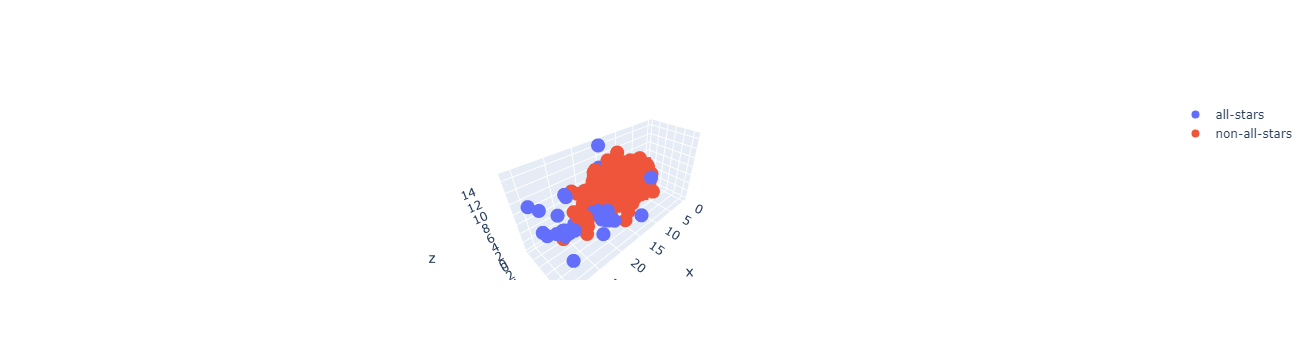

In [137]:
allstar_2022 = allstar_selections_data[allstar_selections_data["season"] == 2022]
allstar_2022_list = allstar_2022["player"].tolist()
allstar_2023 = allstar_selections_data[allstar_selections_data["season"] == 2023]
allstar_2023_list = allstar_2023["player"].tolist()
player_per_game_data = pd.read_csv("Player Per Game.csv")
allstar_2022_player_data = player_per_game_data[player_per_game_data["season"] == 2022]
not_allstar_2022_player_data = allstar_2022_player_data.loc[~allstar_2022_player_data["player"].isin(allstar_2022_list)]
allstar_2022_player_data = allstar_2022_player_data.loc[allstar_2022_player_data["player"].isin(allstar_2022_list)]
allstar_2023_player_data = player_per_game_data[player_per_game_data["season"] == 2023]
not_allstar_2023_player_data = allstar_2023_player_data.loc[~allstar_2023_player_data["player"].isin(allstar_2023_list)]
allstar_2023_player_data = allstar_2023_player_data.loc[allstar_2023_player_data["player"].isin(allstar_2023_list)]
allstar_2023_player_data = allstar_2023_player_data[["season", "player", "pos", "pts_per_game", "ast_per_game", "trb_per_game"]]
allstar_2022_player_data = allstar_2022_player_data[["season", "player", "pos", "pts_per_game", "ast_per_game", "trb_per_game"]]
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=allstar_2022_player_data['pts_per_game'], y=allstar_2022_player_data['ast_per_game'], z=allstar_2022_player_data['trb_per_game'],
                                   mode='markers', text=allstar_2022_player_data['player'], name='all-stars'))
fig.add_trace(go.Scatter3d(x=not_allstar_2022_player_data['pts_per_game'], y=not_allstar_2022_player_data['ast_per_game'], z=not_allstar_2022_player_data['trb_per_game'],
                                   mode='markers', text=not_allstar_2022_player_data['player'], name='non-all-stars'))
fig.show()

## KNN Classifier test

In [107]:
# for n in range(1,10):
#     X_train, X_test, y_train, y_test = generate_train_test_data()
#     knn = KNeighborsClassifier(n_neighbors = n)
#     knn.fit(X_train,y_train)
#     print("Number of neighbors: ", n)
#     print("Train data results:", knn.score(X_train, y_train))
#     print("Test data results:", knn.score(X_test, y_test))
#     print()
# 3 typically yielded the best results
X_train, X_test, y_train, y_test = generate_train_test_data()
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
print("Number of neighbors: ", 3)
print("Train data results:", knn.score(X_train, y_train))
print("Test data results:", knn.score(X_test, y_test))

Number of neighbors:  3
Train data results: 0.9732741156303568
Test data results: 0.9504518541601745


### TODO: Add PCA and possibly SVM to this to see, do various numbers of features

### How well would it have done this year?

In [142]:
X_train, X_test, y_train, y_test = generate_train_test_data('1973.2023', 0)
# Training model with all the test data minus 2023 (what we will predict)
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
print("Train data results:", knn.score(X_train, y_train))
tagged_data_2023 = tagged_player_per_game_data[tagged_player_per_game_data["season"] == 2023]
playernames_2023 = tagged_data_2023['player'].tolist()
X = tagged_data_2023.drop(columns=['player', 'pos', 'season', 'is-all-star', 'lg', 'tm'])
y = tagged_data_2023['is-all-star'].values
predictions_2023 = knn.predict(X).tolist()
print("2023 results:", knn.score(X, y))

Train data results: 0.9727173283572486
2023 results: 0.9561752988047809


### Diving deeper into 2023 and who was actually selected and who was not

In [143]:
actual_2023_allstars_names = allstar_selections_data[allstar_selections_data["season"] == 2023]["player"].tolist()
all_stars_predicted = [(playernames_2023[i]) for i in range(len(predictions_2023)) if predictions_2023[i] == 1]
print(all_stars_predicted)

['Anthony Davis', 'Bojan Bogdanović', 'Bradley Beal', 'Brandon Ingram', 'Damian Lillard', 'Darius Garland', "De'Aaron Fox", 'DeMar DeRozan', 'Devin Booker', 'Donovan Mitchell', 'Fred VanVleet', 'Giannis Antetokounmpo', 'Jalen Brunson', 'James Harden', 'Jaylen Brown', 'Jayson Tatum', 'Joel Embiid', 'Jrue Holiday', 'Julius Randle', 'Kawhi Leonard', 'Kevin Durant', 'Klay Thompson', 'Kyle Kuzma', 'Kyrie Irving', 'Lauri Markkanen', 'LeBron James', 'Luka Dončić', 'Nikola Jokić', 'Pascal Siakam', 'Paul George', 'Russell Westbrook', 'Shai Gilgeous-Alexander', 'Stephen Curry', 'Trae Young', 'Zach LaVine']


In [153]:
print("Number of actual all-stars selected:", len(actual_2023_allstars_names), " Number model selected:", len(all_stars_predicted))

Number of actual all-stars selected: 27  Number model selected: 35


### Taking the intersection of our model and the actual results

In [155]:
intersection_lists = list(set(all_stars_predicted) & set(actual_2023_allstars_names))
print(intersection_lists)
print(len(intersection_lists))

['Jrue Holiday', 'Kevin Durant', 'Damian Lillard', 'Luka Dončić', 'Nikola Jokić', 'Paul George', 'Jayson Tatum', 'LeBron James', 'Julius Randle', 'Stephen Curry', "De'Aaron Fox", 'Lauri Markkanen', 'Jaylen Brown', 'Giannis Antetokounmpo', 'Kyrie Irving', 'Shai Gilgeous-Alexander', 'Pascal Siakam', 'Joel Embiid', 'Donovan Mitchell', 'DeMar DeRozan']
20


### Looking at the differences between our model and the actual results

In [156]:
falsely_predicted = [i for i in all_stars_predicted if i not in actual_2023_allstars_names]
print(falsely_predicted)
print(len(falsely_predicted))

['Anthony Davis', 'Bojan Bogdanović', 'Bradley Beal', 'Brandon Ingram', 'Darius Garland', 'Devin Booker', 'Fred VanVleet', 'Jalen Brunson', 'James Harden', 'Kawhi Leonard', 'Klay Thompson', 'Kyle Kuzma', 'Russell Westbrook', 'Trae Young', 'Zach LaVine']
15


In [157]:
not_predicted = [i for i in actual_2023_allstars_names if i not in all_stars_predicted]
print(not_predicted)
print(len(not_predicted))

['Bam Adebayo', 'Ja Morant', 'Domantas Sabonis', 'Anthony Edwards', 'Tyrese Haliburton', 'Jaren Jackson Jr.', 'Zion Williamson']
7


In [162]:
# Sanity check
total_misclassified = len(falsely_predicted + not_predicted)
total_data_points = len(y)
accuracy = 1 - (total_misclassified / total_data_points)
print("Total Accuracy", accuracy, knn.score(X, y))

Total Accuracy 0.9561752988047809 0.9561752988047809


### TODO: graphs of the players not classified or misclassified for different features
### Make some analysis of why certain players got in or not (position restrictions, injuries, fan favorites)

### TODO: population and franchise analysis/correlation